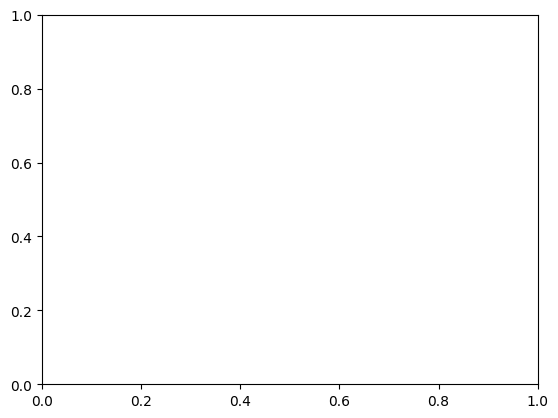

In [1]:
import json
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from oceantracker.post_processing.read_output_files.load_output_files import load_track_data
from oceantracker.post_processing.read_output_files.load_output_files import get_case_info_files_from_dir
from oceantracker.post_processing.read_output_files.load_output_files import read_case_info_file
from oceantracker.post_processing.read_output_files.load_output_files import load_concentration_data

from oceantracker.post_processing.transect_projection.transect import Transect

from oceantracker.post_processing.plotting.plot_collapse import hexmap_of_particle_prop
from oceantracker.post_processing.plotting.plot_collapse import hexmap_of_fraction_above_threshold
from oceantracker.post_processing.plotting.plot_collapse import hexmap_of_death


from oceantracker.post_processing.plotting.plot_collapse import plot_depth_along_transect
from oceantracker.post_processing.plotting.plot_collapse import plot_part_prop_along_transect
from oceantracker.post_processing.plotting.plot_collapse import plot_relative_depth_along_transect

from oceantracker.post_processing.plotting.plot_tracks import animate_particles

#cm
import matplotlib.cm as cm

In [2]:
def slice_and_fill_subset(df,indices,cases):
    for ii in indices:
        # print(len(cases))
        # print(ii)
        # print within the same line and overwrite each time the loop runs again
        print(f'\rProcessing case: {ii:03}/{len(cases):03}', end='', flush=True)
        

        case = cases[ii]

    # check if a column with 'died_by_salinity' exists
        if 'died_by_salinity' not in df.columns:
        # add columns
            df['died_by_salinity'] = np.nan
            df['died_by_depth'] = np.nan
            df['died_by_stranding'] = np.nan
            df['died_in_total'] = np.nan


    # test if "died_by_stranding" is not nan for that row
        if np.isnan(df.loc[ii, 'died_by_stranding']):
            track_data = load_track_data(case)

            cause_of_death = track_data['cause_of_death']
            cause_of_death = cause_of_death[-1,:]

            cause_of_death_without_survivers = cause_of_death[cause_of_death != 0]
            cause_of_death_without_survivers = cause_of_death_without_survivers[~np.isnan(cause_of_death_without_survivers)]

            df.loc[ii, 'died_by_salinity'] = np.sum(cause_of_death_without_survivers == 1)
            df.loc[ii, 'died_by_depth'] = np.sum(cause_of_death_without_survivers == 2)
            df.loc[ii, 'died_by_stranding'] = np.sum(cause_of_death_without_survivers == 3)
            df.loc[ii, 'died_in_total'] = len(cause_of_death_without_survivers)
        # if ii > 2:
        #     break

# make a copy of the subset of the dataframe
    subset = df.loc[indices].copy()

# sort subset by stickiness
    subset = subset.sort_values(by='stickiness')

    return subset



def read_key_params_from_cases(cases):

    # reading cases and sorting thru them
    df = pd.DataFrame(columns=['initial_size', 'stickiness', 'light_limitation_threshold', 'light_limited_culling_prop'])

    for ii, case in enumerate(cases):
        case_info = read_case_info_file(case)

        initial_size = case_info['full_case_params']['class_dicts']['particle_properties']['radius_spherical']['initial_value']
        stickiness = case_info['full_case_params']['class_dicts']['particle_properties']['collision_very_fine_silt']['stickyness']
        light_limitation_threshold = case_info['full_case_params']['class_dicts']['trajectory_modifiers']['light_starvation_induced_mortality']['required_illumination']
        light_limited_culling_prop = case_info['full_case_params']['class_dicts']['trajectory_modifiers']['light_starvation_induced_mortality']['probability_of_culling']

        df.loc[ii] = [initial_size, stickiness, light_limitation_threshold, light_limited_culling_prop]

    return df

In [3]:
# set context paper
sns.set_context("paper")

In [12]:
def plot_relative_cause_for_death(subset, variant='stickiness'):
    sns.set_palette("ch:rot=-.25,hue=1,light=.75", n_colors=3)
    # set font to roboto mono thin


    plt.figure(figsize=(8.3/2.53, (8.3/1.4)/2.53), dpi=300)
    # plt.stackplot(df['stickyness'], df['rel_1'], df['rel_2'], df['rel_3'], labels=['washed out', 'sinking', 'stranding'], baseline='zero')
    plt.stackplot(subset[variant],
                subset['died_by_stranding']/subset['died_in_total'],
                subset['died_by_depth']/subset['died_in_total'], 
                subset['died_by_salinity']/subset['died_in_total'],
                labels=['stranding','light limitation','salinity/outwashing'], baseline='zero')
    plt.xlabel(variant)
    plt.ylabel('relative mortality')
    # plt.title('Stacked Line Plot with Stickyness on X-axis')
    plt.legend()
    plt.xlim(0,1)
    plt.ylim(0,1)

    # remove frame
    sns.despine(bottom=True, left=True)
    # make tick marks thinner and gray
    plt.tick_params(width=0.5 , color='gray')

    # add gray grid
    plt.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
    

## v51

In [13]:
path_to_dir = '/scratch/local1/output/22_11_01_depth_losses_v51'

cases = get_case_info_files_from_dir(path_to_dir)
df = read_key_params_from_cases(cases)

In [14]:
subset = slice_and_fill_subset(df, df.index, cases)

Processing case: 039/040

Processing case: 028/040

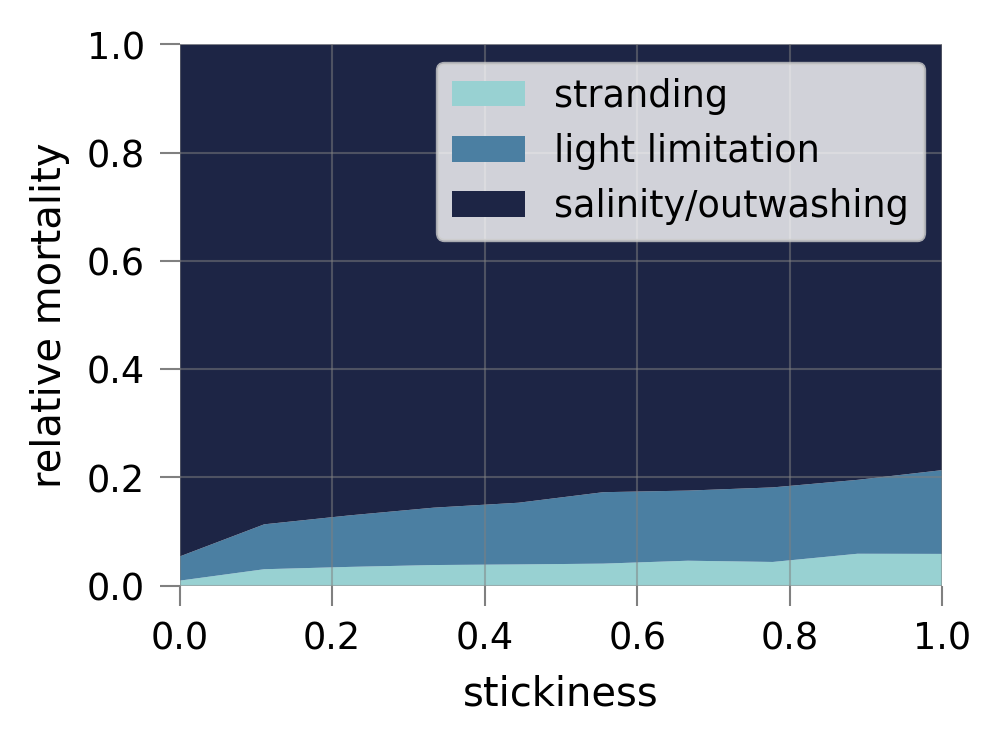

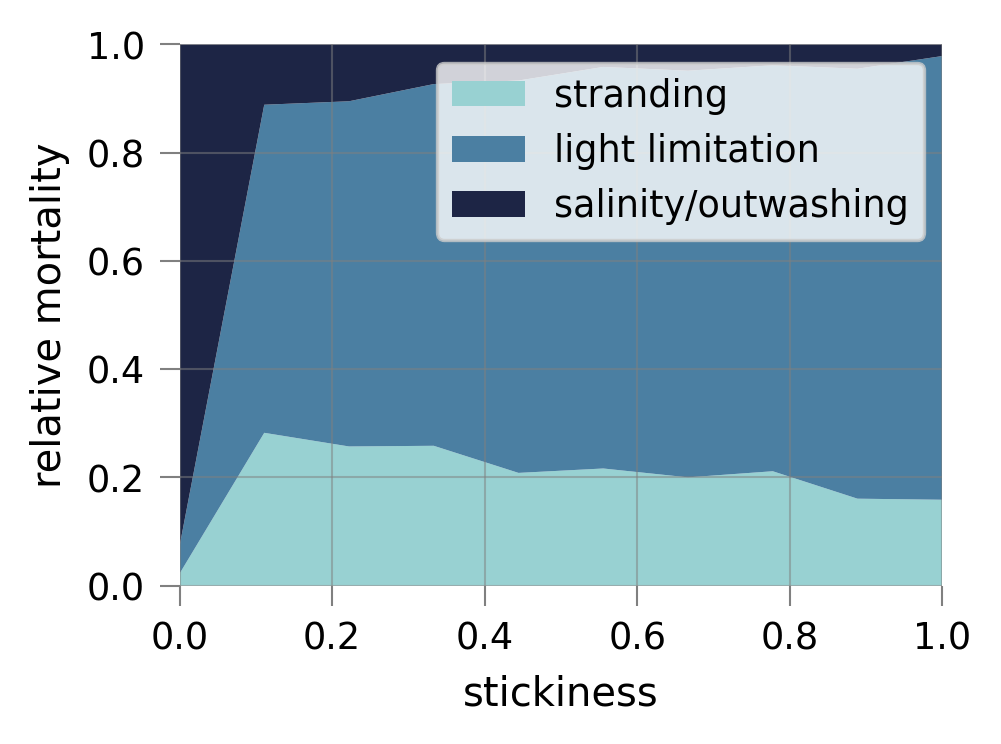

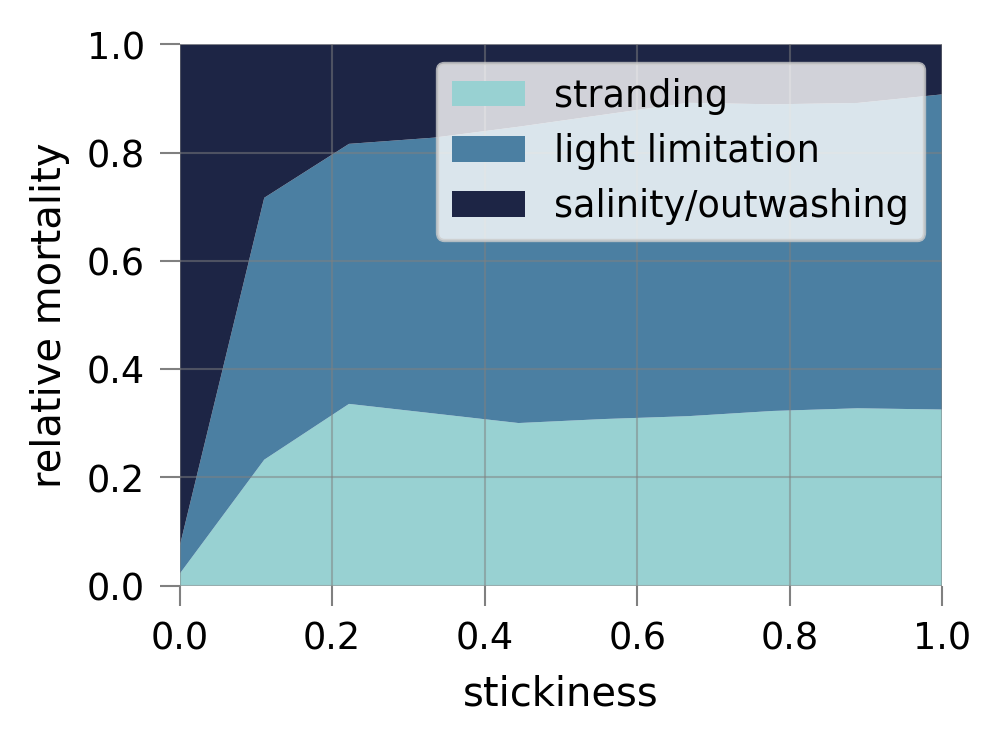

In [15]:
# get unique set of initial sized:
initial_sizes = set(df['initial_size'])

for size in initial_sizes:

    indices = df[(df['initial_size'] == size) & (df['light_limitation_threshold'] == 30) & (df['light_limited_culling_prop'] == 3.56e-05)].index
    subset = slice_and_fill_subset(df, indices, cases)
    # drop row 28

    plot_relative_cause_for_death(subset)

Processing case: 034/040

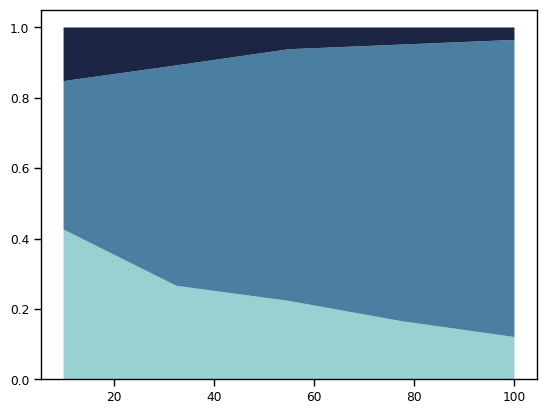

In [31]:
indices = df[(df['initial_size'] == 0.00005) & (df['stickiness'] == 1.000000) & (df['light_limited_culling_prop'] == 3.56e-05)].index
subset = slice_and_fill_subset(df, indices, cases)
subset = subset.drop(28)

plt.stackplot(subset['light_limitation_threshold'],
            subset['died_by_stranding']/subset['died_in_total'],
            subset['died_by_depth']/subset['died_in_total'], 
            subset['died_by_salinity']/subset['died_in_total'],
            labels=['stranding','light limitation','salinity/outwashing'], baseline='zero')

Processing case: 039/040

,initial_size,stickiness,light_limitation_threshold,light_limited_culling_prop,died_by_salinity,died_by_depth,died_by_stranding,died_in_total
35,0.00005,1.0,30.0,0.000004,107.0,147.0,289.0,543.0
36,0.00005,1.0,30.0,0.000092,97.0,664.0,247.0,1008.0
37,0.00005,1.0,30.0,0.000180,69.0,754.0,235.0,1058.0
38,0.00005,1.0,30.0,0.000268,47.0,856.0,215.0,1118.0
39,0.00005,1.0,30.0,0.000356,49.0,909.0,222.0,1180.0


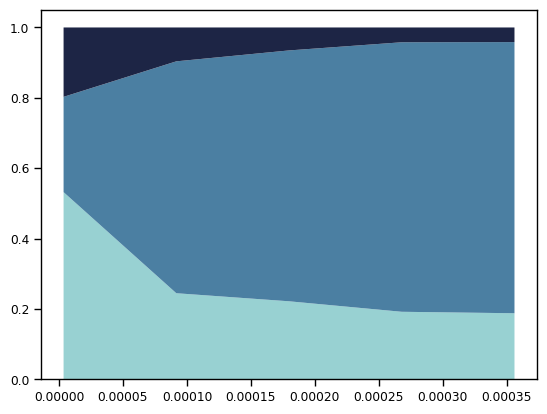

In [37]:
indices = df[(df['initial_size'] == 0.00005) & (df['stickiness'] == 1.000000) & (df['light_limitation_threshold'] == 30)].index
subset = slice_and_fill_subset(df, indices, cases)
subset = subset.drop(28)

plt.stackplot(subset['light_limited_culling_prop'],
            subset['died_by_stranding']/subset['died_in_total'],
            subset['died_by_depth']/subset['died_in_total'], 
            subset['died_by_salinity']/subset['died_in_total'],
            labels=['stranding','light limitation','salinity/outwashing'], baseline='zero')

subset

In [36]:
df

,initial_size,stickiness,light_limitation_threshold,light_limited_culling_prop,died_by_salinity,died_by_depth,died_by_stranding,died_in_total
0,0.00001,0.000000,30.0,0.000036,2420.0,114.0,24.0,2558.0
1,0.00005,0.000000,30.0,0.000036,2320.0,125.0,54.0,2499.0
2,0.00010,0.000000,30.0,0.000036,2134.0,116.0,51.0,2301.0
3,0.00001,0.111111,30.0,0.000036,1859.0,174.0,64.0,2097.0
4,0.00005,0.111111,30.0,0.000036,298.0,509.0,245.0,1052.0
5,0.00010,0.111111,30.0,0.000036,95.0,517.0,241.0,853.0
6,0.00001,0.222222,30.0,0.000036,1775.0,194.0,71.0,2040.0
7,0.00005,0.222222,30.0,0.000036,164.0,429.0,300.0,893.0
8,0.00010,0.222222,30.0,0.000036,93.0,565.0,228.0,886.0
9,0.00001,0.333333,30.0,0.000036,1655.0,205.0,74.0,1934.0


## v50

In [15]:
path_to_dir = '/scratch/local1/output/22_11_01_depth_losses_v50'

cases = get_case_info_files_from_dir(path_to_dir)
df = read_key_params_from_cases(cases)

In [16]:
subset = slice_and_fill_subset(df, df.index, cases)

Processing case: 002/040

/home/zmaw/u301513/Documents/scr/phd/bicest/oceantracker/oceantracker/util/ncdf_util.py:169: UserWarning: WARNING: _FillValue not used since it
cannot be safely cast to variable data type
  dtype = self.file_handle.variables[name][0].dtype


Processing case: 039/040

Processing case: 028/040

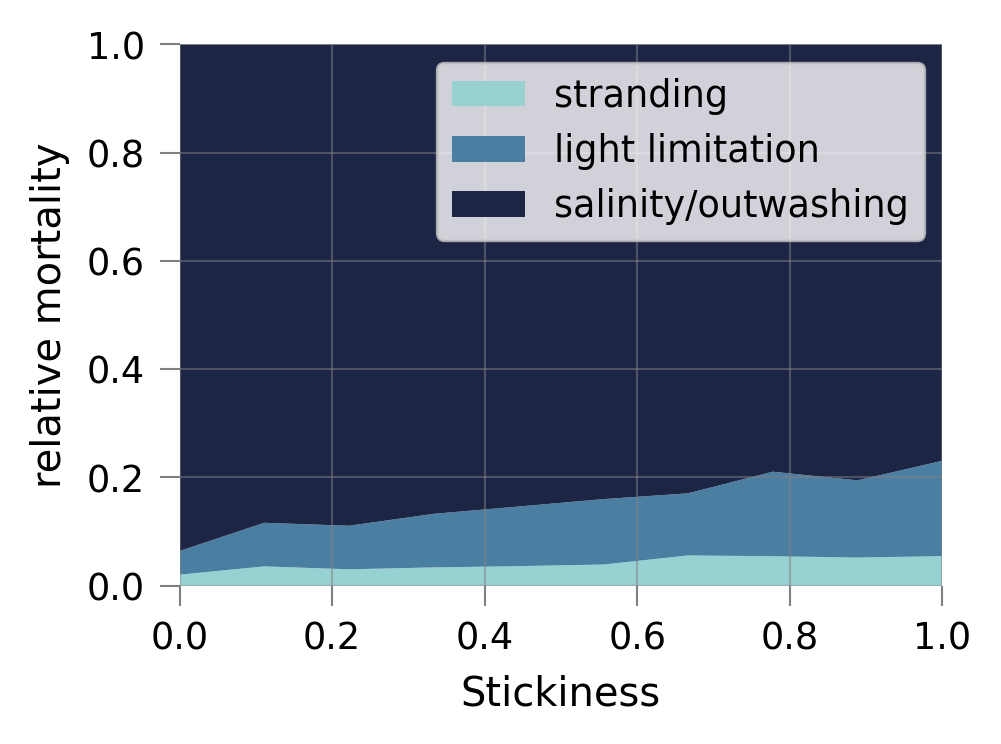

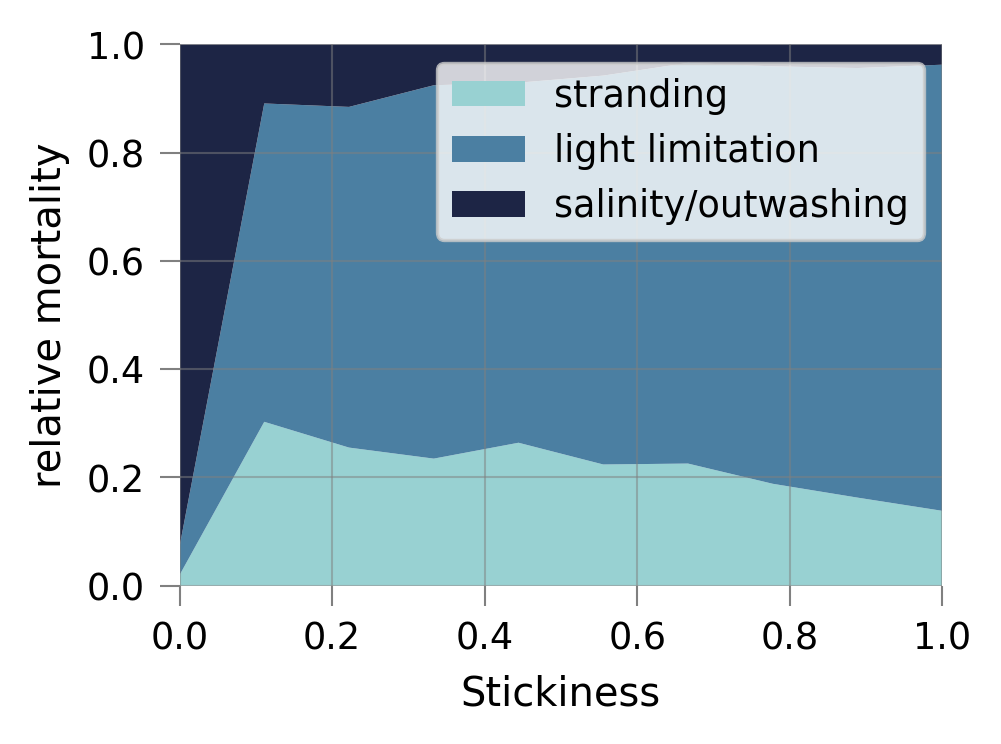

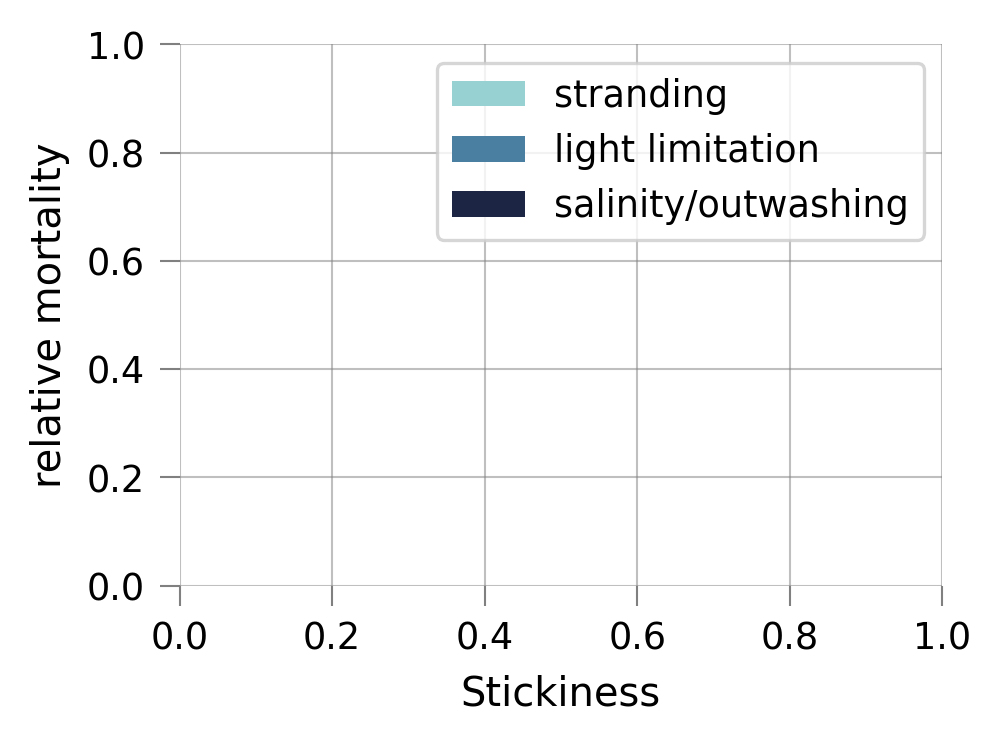

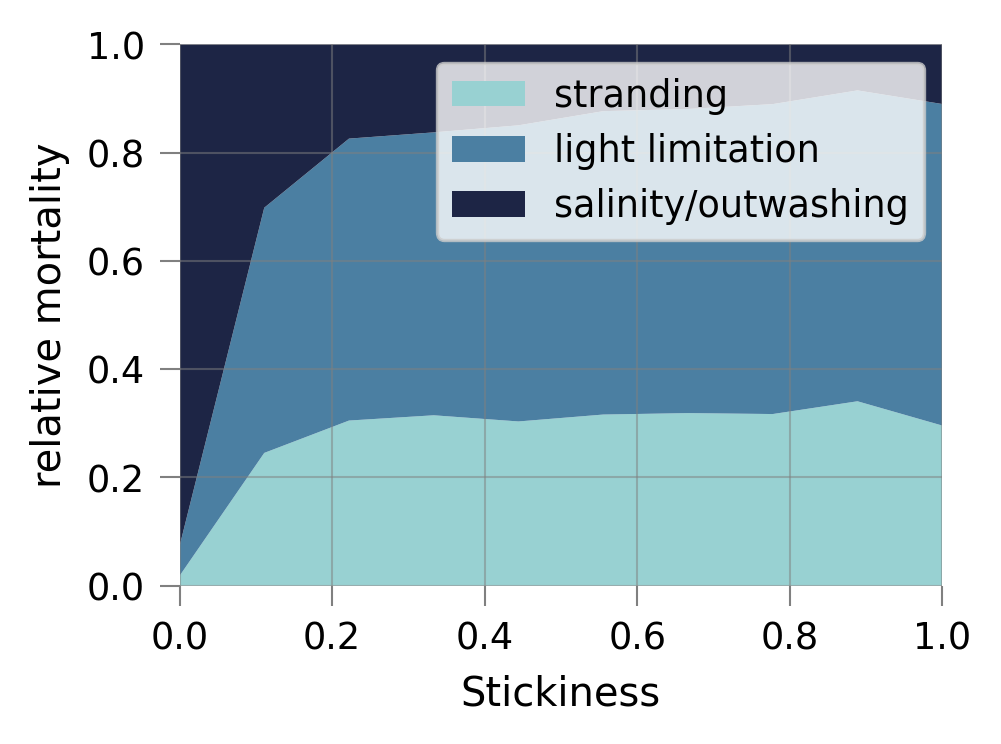

In [39]:
# get unique set of initial sized:
initial_sizes = set(df['initial_size'])

for size in initial_sizes:

    indices = df[(df['initial_size'] == size) & (df['light_limitation_threshold'] == 30) & (df['light_limited_culling_prop'] == 3.56e-05)].index
    subset = slice_and_fill_subset(df, indices, cases)

    plot_relative_cause_for_death(subset)

In [6]:
indices = df[(df['initial_size'] == 5e-5) & (df['light_limitation_threshold'] == 30) & (df['light_limited_culling_prop'] == 3.56e-05)].index

indices

Index([1, 4, 7, 10, 13, 16, 19, 22, 25, 28], dtype='int64')

Processing case: 028/040

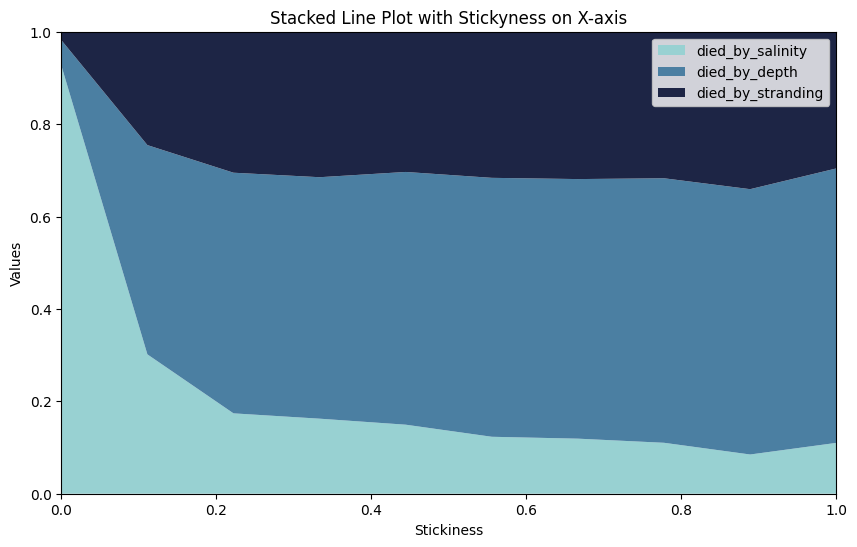

In [7]:
subset = slice_and_fill_subset(df, indices, cases)

plot_relative_cause_for_death(subset)

827


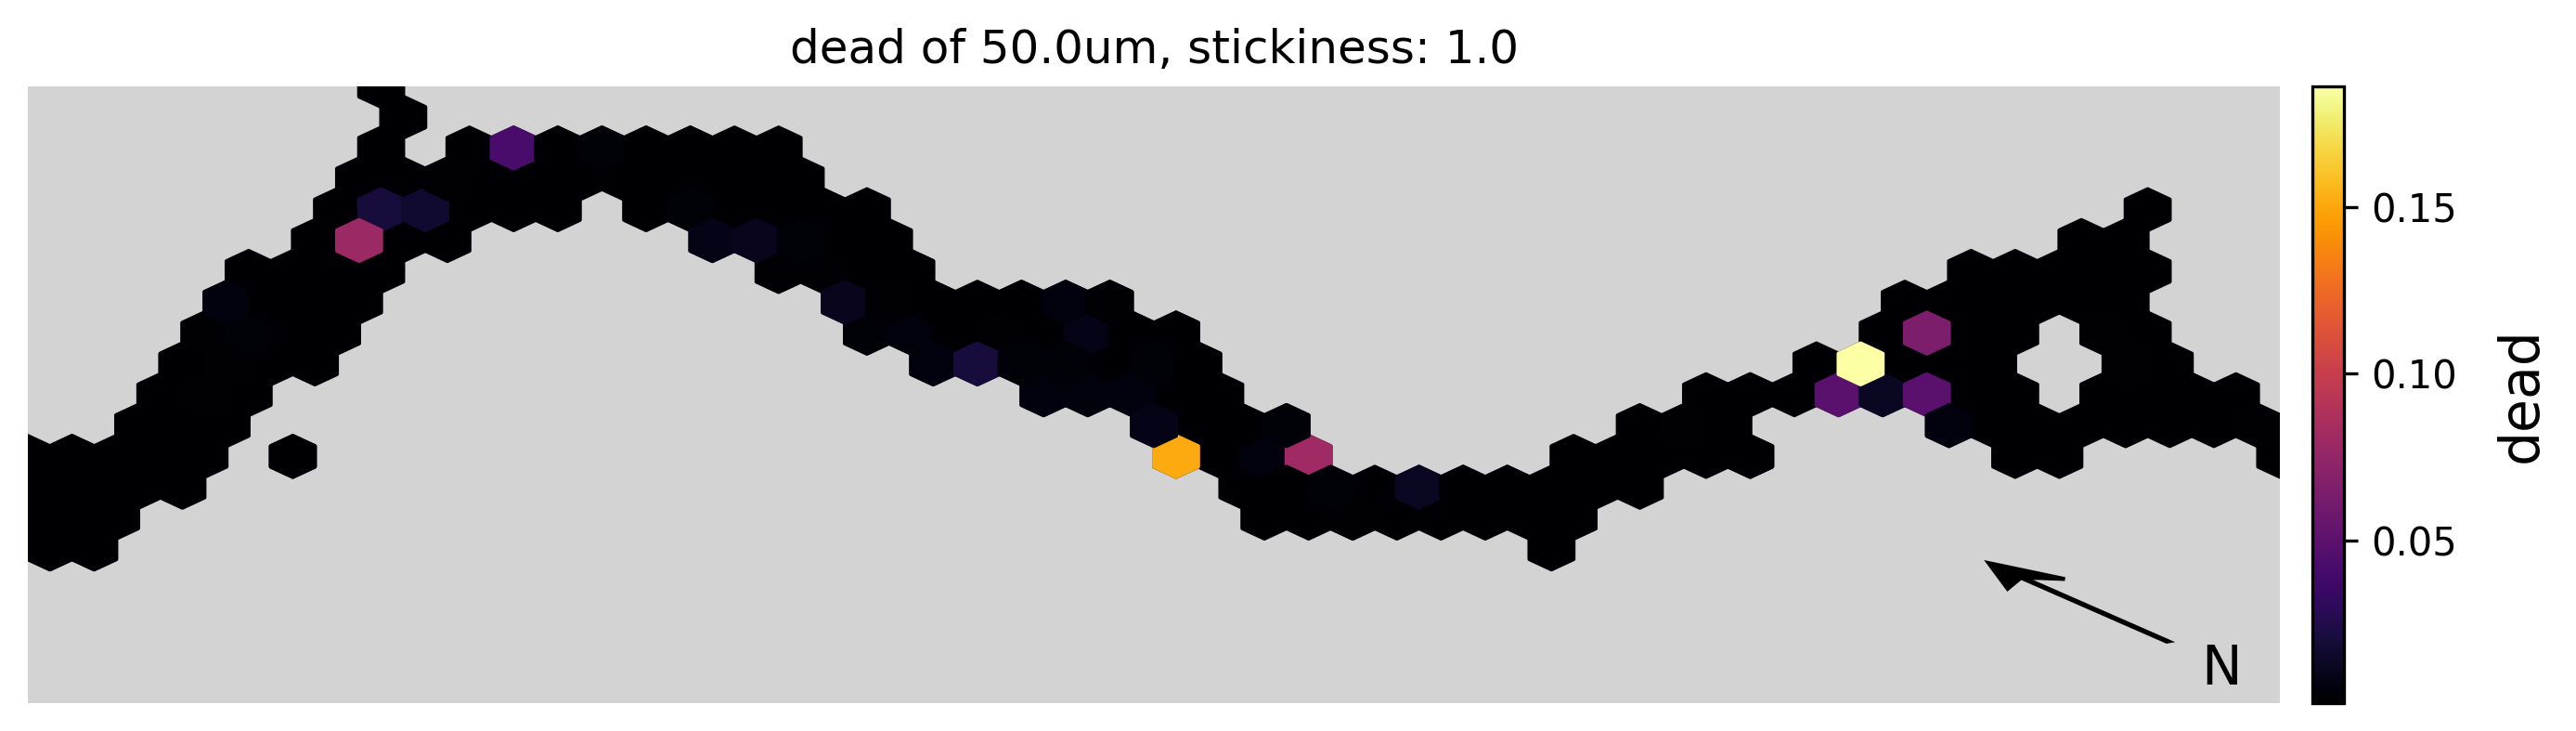

In [23]:
hexmap_of_death(cases[13],vmin=None,vmax=None,num_bins=10)

2259


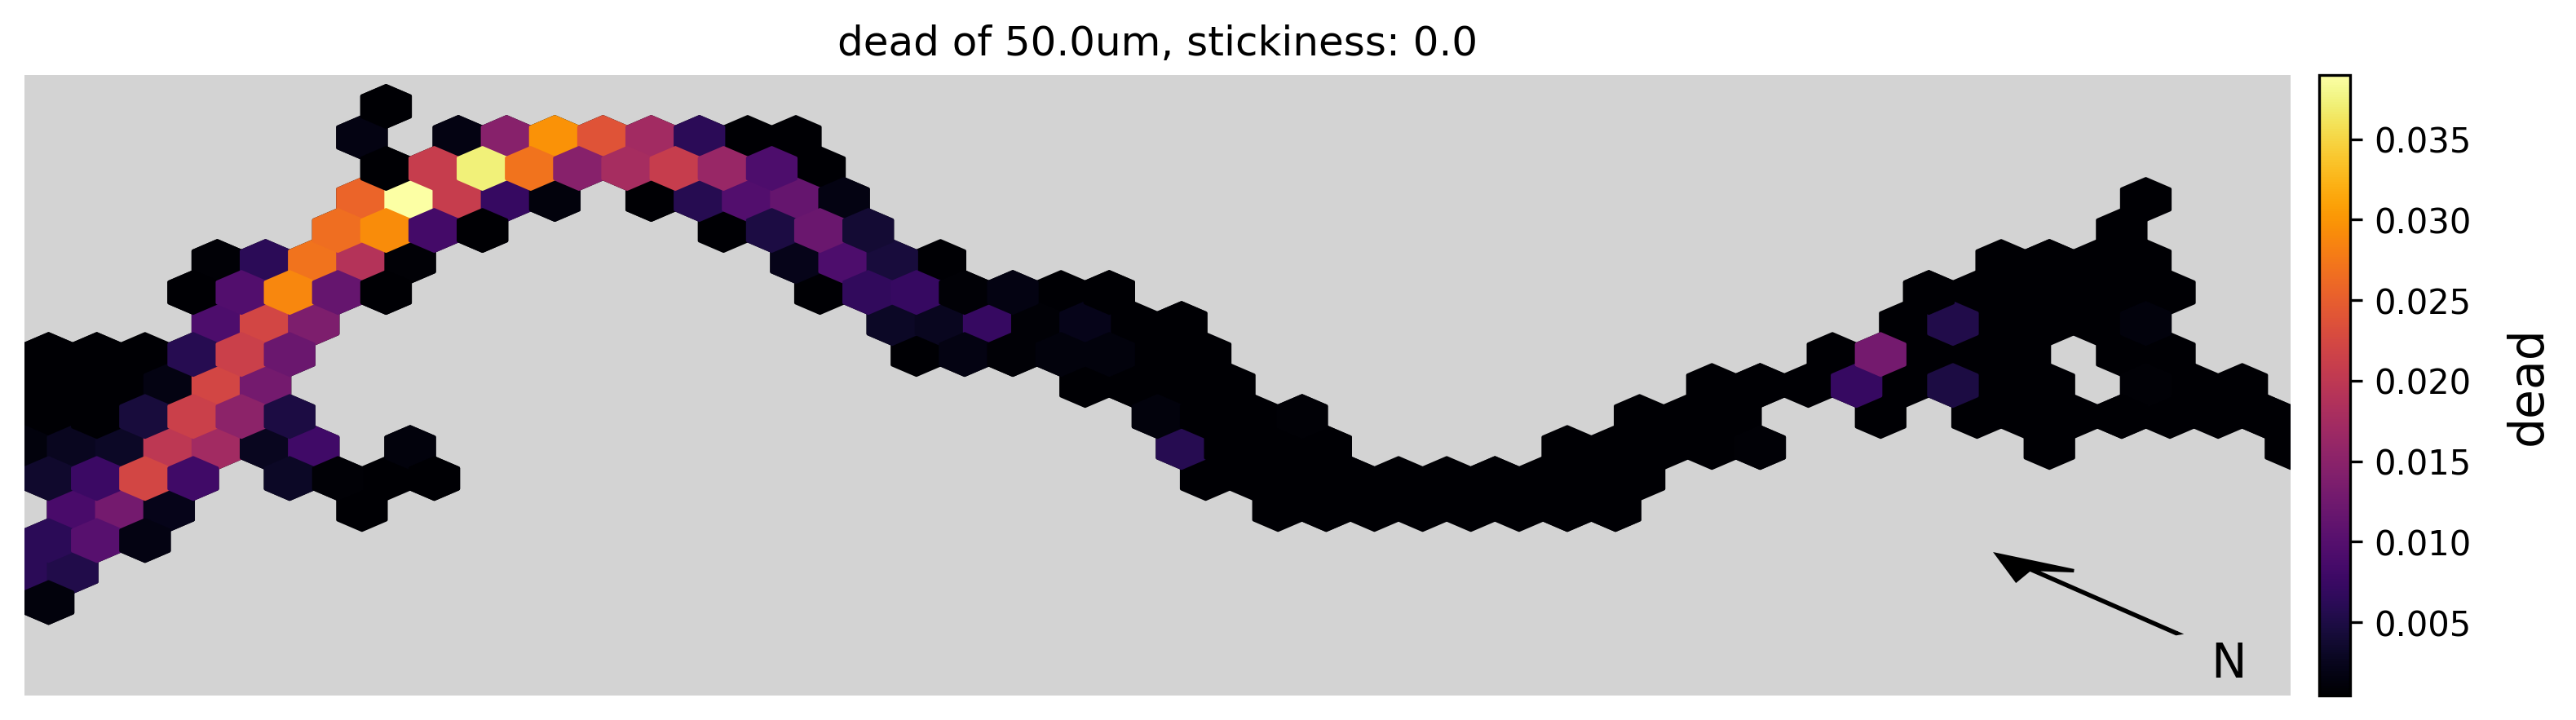

In [24]:
hexmap_of_death(cases[1],vmin=None,vmax=None,num_bins=10)

# v48

In [3]:
path_to_dir = '/scratch/local1/output/22_11_01_depth_losses_v48'

cases = get_case_info_files_from_dir(path_to_dir)

In [4]:
# reading cases and sorting thru them
df = pd.DataFrame(columns=['initial_size', 'stickiness', 'light_limitation_threshold', 'light_limited_culling_prop'])

for ii, case in enumerate(cases):
    case_info = read_case_info_file(case)

    initial_size = case_info['full_case_params']['class_dicts']['particle_properties']['radius_spherical']['initial_value']
    stickiness = case_info['full_case_params']['class_dicts']['particle_properties']['collision_very_fine_silt']['stickyness']
    light_limitation_threshold = case_info['full_case_params']['class_dicts']['trajectory_modifiers']['light_starvation_induced_mortality']['required_illumination']
    light_limited_culling_prop = case_info['full_case_params']['class_dicts']['trajectory_modifiers']['light_starvation_induced_mortality']['probability_of_culling']

    df.loc[ii] = [initial_size, stickiness, light_limitation_threshold, light_limited_culling_prop]

In [1]:
# get indices of all cases with initial size 1e-5, light threshold 30 and culling 3.56e-05
indices = df[(df['initial_size'] == 5e-5)].index

subset = slice_and_fill_subset(df, indices, cases)
print(subset)

plot_relative_cause_for_death(subset)

NameError: name 'df' is not defined

2300


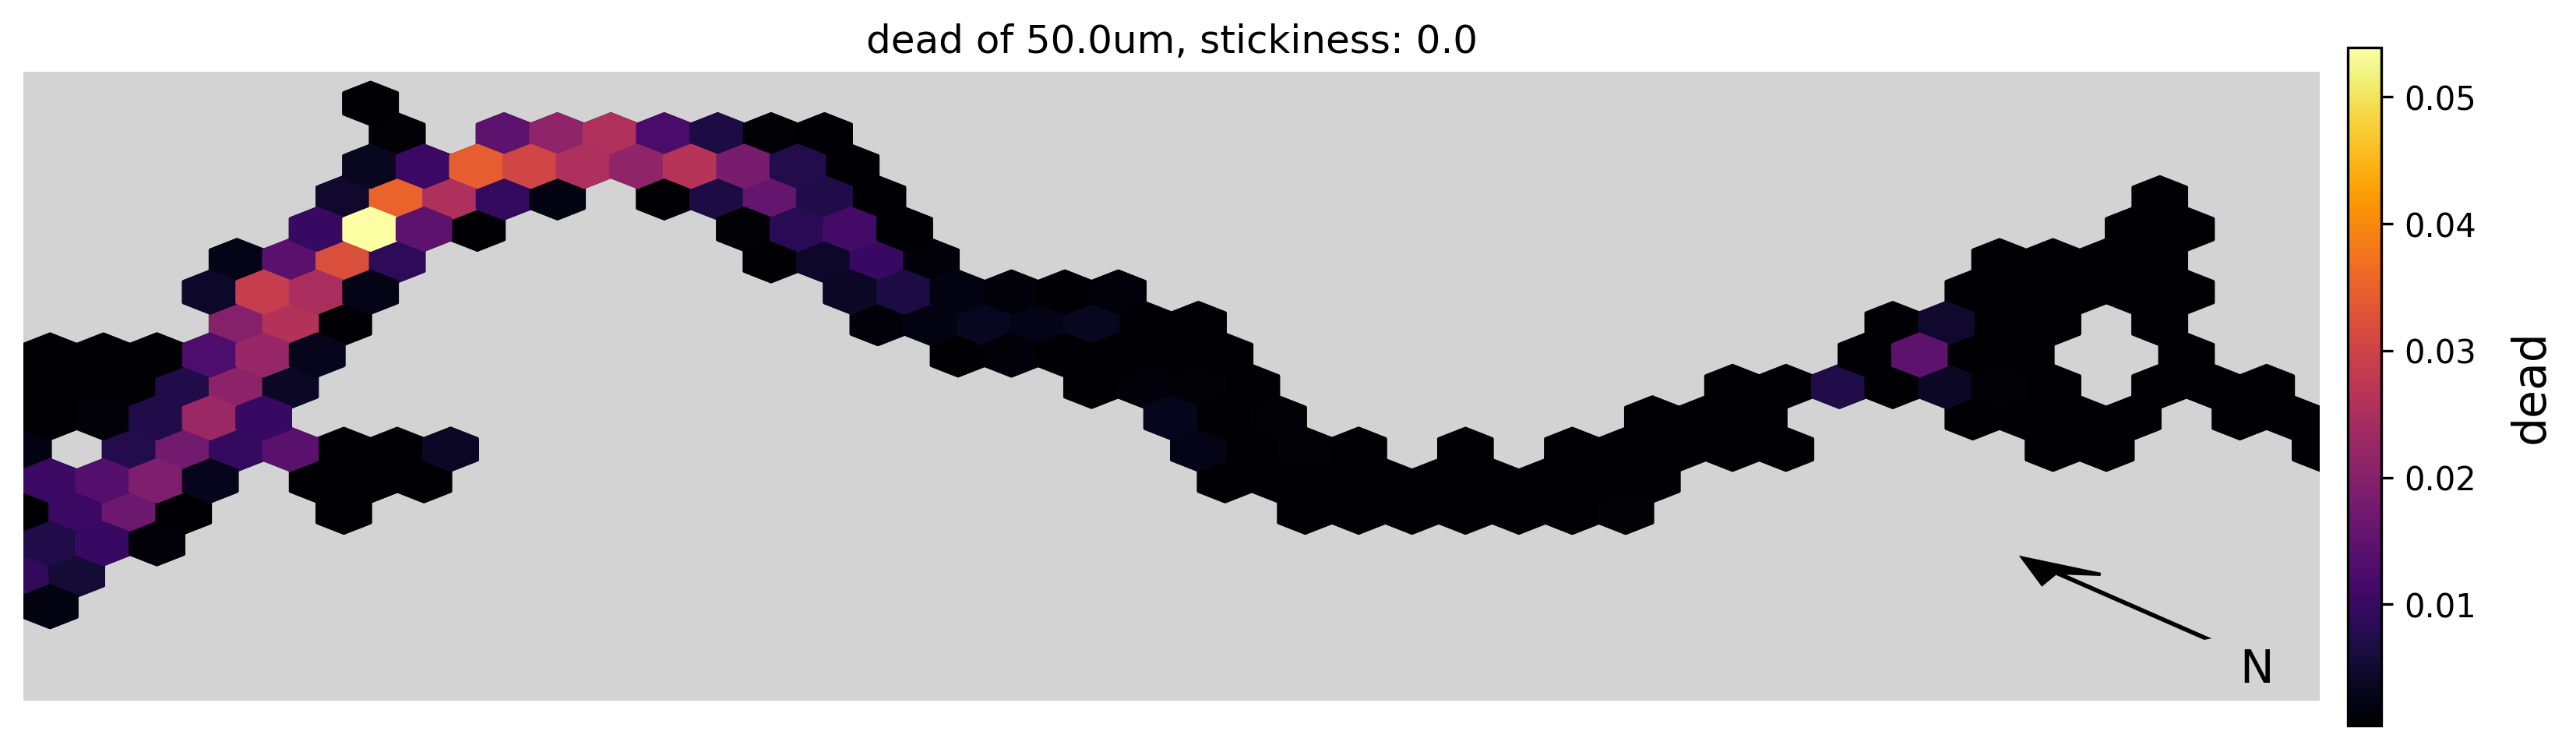

In [6]:
hexmap_of_death(cases[2],vmin=None,vmax=None,num_bins=10)

848


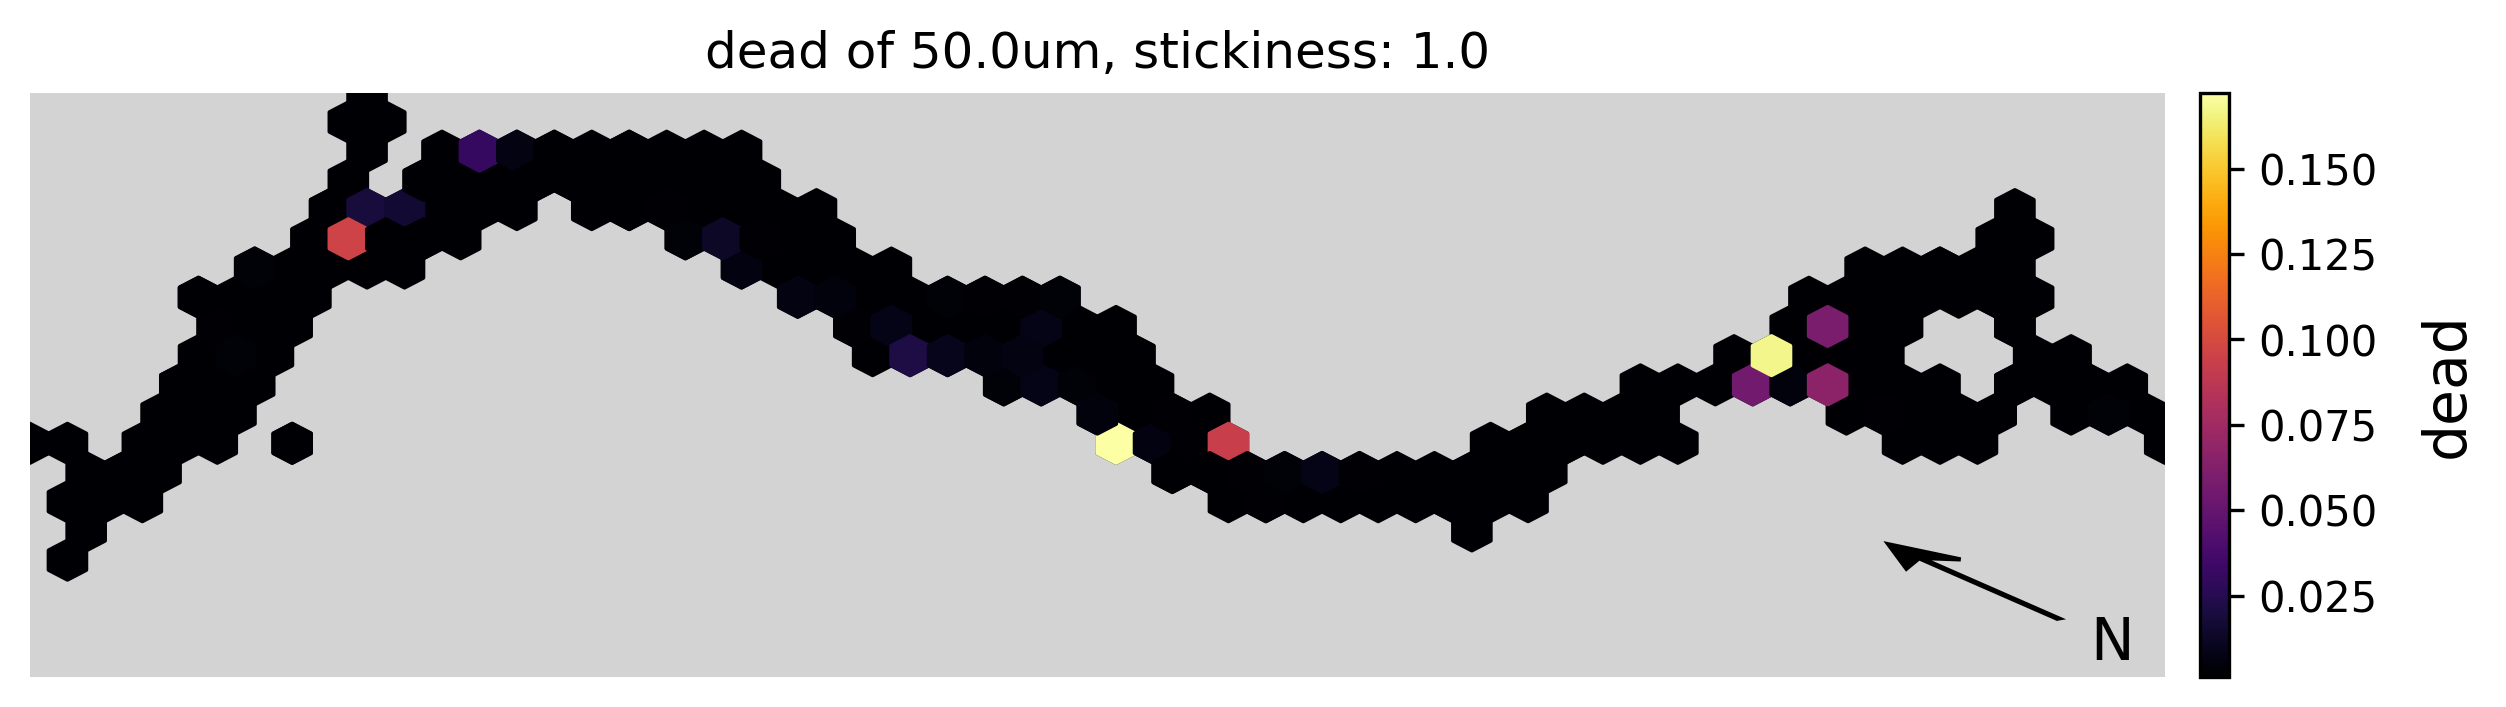

In [7]:
hexmap_of_death(cases[8],vmin=None,vmax=None,num_bins=10)

In [51]:
full_column = load_concentration_data(cases[2],name='full_coloumn')

In [52]:
top_layer = full_column

In [9]:
_ = [print(item) for item in top_layer.keys()]

release_groupID
release_locations
time
particle_count
particle_concentration
load_concentration
release_points
number_of_release_points
is_polygon_release
grid
particle_status_flags
particle_release_groups
full_case_params


In [57]:
x = top_layer['grid']['x'][:,0]
y = top_layer['grid']['x'][:,1]
tri = top_layer['grid']['triangles']
c = top_layer['particle_concentration']
c = np.sum(c[90:], axis=0)

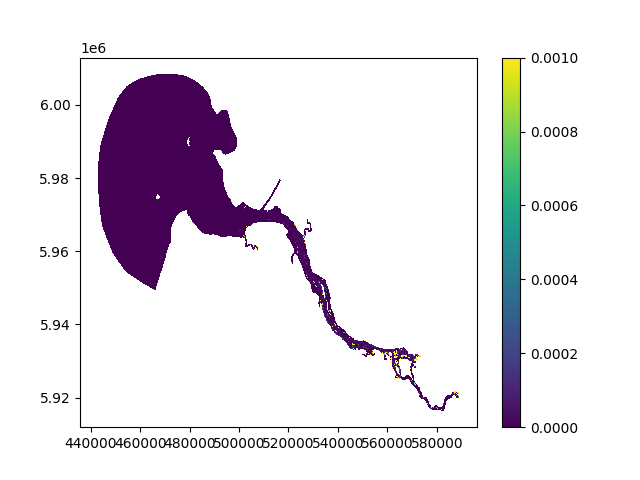

In [66]:
%matplotlib widget
plt.figure()
plt.tripcolor(x, y, tri,facecolors=c, vmax=1e-3 )
plt.colorbar()

# v44

In [3]:
path_to_dir = '/scratch/local1/output/22_11_01_depth_losses_v44'

cases = get_case_info_files_from_dir(path_to_dir)

In [4]:
# reading cases and sorting thru them
df = pd.DataFrame(columns=['initial_size', 'stickiness', 'light_limitation_threshold', 'light_limited_culling_prop'])

for ii, case in enumerate(cases):
    case_info = read_case_info_file(case)

    initial_size = case_info['full_case_params']['class_dicts']['particle_properties']['radius_spherical']['initial_value']
    stickiness = case_info['full_case_params']['class_dicts']['particle_properties']['collision_very_fine_silt']['stickyness']
    light_limitation_threshold = case_info['full_case_params']['class_dicts']['trajectory_modifiers']['light_starvation_induced_mortality']['required_illumination']
    light_limited_culling_prop = case_info['full_case_params']['class_dicts']['trajectory_modifiers']['light_starvation_induced_mortality']['probability_of_culling']

    df.loc[ii] = [initial_size, stickiness, light_limitation_threshold, light_limited_culling_prop]

df


,initial_size,stickiness,light_limitation_threshold,light_limited_culling_prop
0,0.0001,0.00,30.0,0.000036
1,0.0001,0.25,30.0,0.000036
2,0.0001,0.50,30.0,0.000036
3,0.0001,0.75,30.0,0.000036
4,0.0001,1.00,30.0,0.000036


In [5]:
# get indices of all cases with initial size 1e-5, light threshold 30 and culling 3.56e-05
indices = df[ (df['light_limitation_threshold'] == 30) & (df['light_limited_culling_prop'] == 3.56e-05)].index

subset = slice_and_fill_subset(df, indices, cases)

df

Processing case: 004/005

,initial_size,stickiness,light_limitation_threshold,light_limited_culling_prop,died_by_salinity,died_by_depth,died_by_stranding,died_in_total
0,0.0001,0.00,30.0,0.000036,331.0,3635.0,16783.0,20749.0
1,0.0001,0.25,30.0,0.000036,1493.0,8979.0,455.0,10927.0
2,0.0001,0.50,30.0,0.000036,1119.0,9334.0,309.0,10762.0
3,0.0001,0.75,30.0,0.000036,969.0,9697.0,199.0,10865.0
4,0.0001,1.00,30.0,0.000036,867.0,9915.0,175.0,10957.0


## v47

In [6]:
path_to_dir = '/scratch/local1/output/22_11_01_depth_losses_v47'

cases = get_case_info_files_from_dir(path_to_dir)

In [7]:
# reading cases and sorting thru them
df = pd.DataFrame(columns=['initial_size', 'stickiness', 'light_limitation_threshold', 'light_limited_culling_prop'])

for ii, case in enumerate(cases):
    case_info = read_case_info_file(case)

    initial_size = case_info['full_case_params']['class_dicts']['particle_properties']['radius_spherical']['initial_value']
    stickiness = case_info['full_case_params']['class_dicts']['particle_properties']['collision_very_fine_silt']['stickyness']
    light_limitation_threshold = case_info['full_case_params']['class_dicts']['trajectory_modifiers']['light_starvation_induced_mortality']['required_illumination']
    light_limited_culling_prop = case_info['full_case_params']['class_dicts']['trajectory_modifiers']['light_starvation_induced_mortality']['probability_of_culling']

    df.loc[ii] = [initial_size, stickiness, light_limitation_threshold, light_limited_culling_prop]

df


,initial_size,stickiness,light_limitation_threshold,light_limited_culling_prop
0,0.000005,0.00,30.0,0.000036
1,0.000010,0.00,30.0,0.000036
2,0.000050,0.00,30.0,0.000036
3,0.000005,0.25,30.0,0.000036
4,0.000010,0.25,30.0,0.000036
5,0.000050,0.25,30.0,0.000036
6,0.000005,0.50,30.0,0.000036
7,0.000010,0.50,30.0,0.000036
8,0.000050,0.50,30.0,0.000036
9,0.000005,0.75,30.0,0.000036


In [8]:
# get indices of all cases with initial size 1e-5, light threshold 30 and culling 3.56e-05
indices = df[ (df['light_limitation_threshold'] == 30) & (df['light_limited_culling_prop'] == 3.56e-05)].index

subset = slice_and_fill_subset(df, indices, cases)


Processing case: 019/021

# v48 debug

In [25]:
path_to_dir = '/scratch/local1/output/22_11_01_depth_losses_v48'

cases = get_case_info_files_from_dir(path_to_dir)

In [29]:
# reading cases and sorting thru them
df = pd.DataFrame(columns=['initial_size', 'stickiness', 'light_limitation_threshold', 'light_limited_culling_prop'])

for ii, case in enumerate(cases):
    case_info = read_case_info_file(case)

    initial_size = case_info['full_case_params']['class_dicts']['particle_properties']['radius_spherical']['initial_value']
    stickiness = case_info['full_case_params']['class_dicts']['particle_properties']['collision_very_fine_silt']['stickyness']
    light_limitation_threshold = case_info['full_case_params']['class_dicts']['trajectory_modifiers']['light_starvation_induced_mortality']['required_illumination']
    light_limited_culling_prop = case_info['full_case_params']['class_dicts']['trajectory_modifiers']['light_starvation_induced_mortality']['probability_of_culling']

    df.loc[ii] = [initial_size, stickiness, light_limitation_threshold, light_limited_culling_prop]

df


,initial_size,stickiness,light_limitation_threshold,light_limited_culling_prop
0,0.000005,1.0,30.0,0.000036
1,0.000010,1.0,30.0,0.000036
2,0.000050,1.0,30.0,0.000036
3,0.000005,1.0,15.0,0.000036
4,0.000005,1.0,30.0,0.000036
5,0.000005,1.0,45.0,0.000036
6,0.000005,1.0,30.0,0.000018
7,0.000005,1.0,30.0,0.000036
8,0.000005,1.0,30.0,0.000053


In [37]:
# get indices of all cases with initial size 1e-5, light threshold 30 and culling 3.56e-05
indices = df[ (df['light_limitation_threshold'] == 30) & (df['light_limited_culling_prop'] == 3.56e-05)].index

subset = slice_and_fill_subset(df, indices, cases)

Processing case: 007/009

In [39]:
np.linspace(0, 1, 3)

array([0. , 0.5, 1. ])

In [38]:
df

,initial_size,stickiness,light_limitation_threshold,light_limited_culling_prop,died_by_salinity,died_by_depth,died_by_stranding,died_in_total
0,0.000005,1.0,30.0,0.000036,58.0,171.0,1826.0,2055.0
1,0.000010,1.0,30.0,0.000036,98.0,247.0,1248.0,1593.0
2,0.000050,1.0,30.0,0.000036,267.0,501.0,80.0,848.0
3,0.000005,1.0,15.0,0.000036,NaN,NaN,NaN,NaN
4,0.000005,1.0,30.0,0.000036,68.0,153.0,1845.0,2066.0
5,0.000005,1.0,45.0,0.000036,NaN,NaN,NaN,NaN
6,0.000005,1.0,30.0,0.000018,NaN,NaN,NaN,NaN
7,0.000005,1.0,30.0,0.000036,59.0,164.0,1815.0,2038.0
8,0.000005,1.0,30.0,0.000053,NaN,NaN,NaN,NaN


In [30]:
non_stick = load_track_data(cases[0])
true_stick = load_track_data(cases[2])

In [34]:
cod = non_stick['cause_of_death'][-1]
len(cod[cod == 1]) # salinity


1826

In [35]:
len(cod[cod == 2]) # depth

171

In [36]:
len(cod[cod == 3]) # stranding

58

In [13]:
list(non_stick)

['file_created',
 'total_num_particles_released',
 'time_steps_written',
 'status_unknown',
 'status_bad_cord',
 'status_cell_search_failed',
 'status_notReleased',
 'status_dead',
 'status_outside_open_boundary',
 'status_frozen',
 'status_stranded_by_tide',
 'status_on_bottom',
 'status_moving',
 'release_groupID_poly1',
 'dimensions',
 'status',
 'x',
 'IDpulse',
 'ID',
 'user_release_groupID',
 'release_points',
 'x_last_good',
 'dry_cell_index',
 'number_of_release_points',
 'is_polygon_release',
 'time_released',
 'density_spherical',
 'num_part_released_so_far',
 'time_step_range',
 'time',
 'cause_of_death',
 'particle_ID',
 'IDrelease_group',
 'particles_written_per_time_step',
 'release_groupID',
 'release_locations',
 'z',
 'grid',
 'particle_status_flags',
 'particle_release_groups',
 'full_case_params',
 'axis_lim']

In [9]:
df

,initial_size,stickiness,light_limitation_threshold,light_limited_culling_prop,died_by_salinity,died_by_depth,died_by_stranding,died_in_total
0,0.000005,0.00,30.0,0.000036,38.0,2689.0,2873.0,5600.0
1,0.000010,0.00,30.0,0.000036,37.0,2676.0,2880.0,5593.0
2,0.000050,0.00,30.0,0.000036,41.0,2608.0,2912.0,5561.0
3,0.000005,0.25,30.0,0.000036,36.0,2631.0,2903.0,5570.0
4,0.000010,0.25,30.0,0.000036,43.0,2651.0,2890.0,5584.0
5,0.000050,0.25,30.0,0.000036,43.0,2628.0,2901.0,5572.0
6,0.000005,0.50,30.0,0.000036,42.0,2553.0,2939.0,5534.0
7,0.000010,0.50,30.0,0.000036,36.0,2647.0,2895.0,5578.0
8,0.000050,0.50,30.0,0.000036,35.0,2626.0,2906.0,5567.0
9,0.000005,0.75,30.0,0.000036,32.0,2571.0,2935.0,5538.0


In [9]:
# get indices of all cases with initial size 1e-5, light threshold 30 and culling 3.56e-05
indices = df[(df['initial_size'] == 1e-5) & (df['light_limitation_threshold'] == 30) & (df['light_limited_culling_prop'] == 3.56e-05)].index

subset = slice_and_fill_subset(df, indices, cases)

plot_relative_cause_for_death(subset)

Index([1, 4, 7, 10, 13, 16, 19, 22, 25, 28], dtype='int64')

21
1
21
4
21
7
21
10
21
13


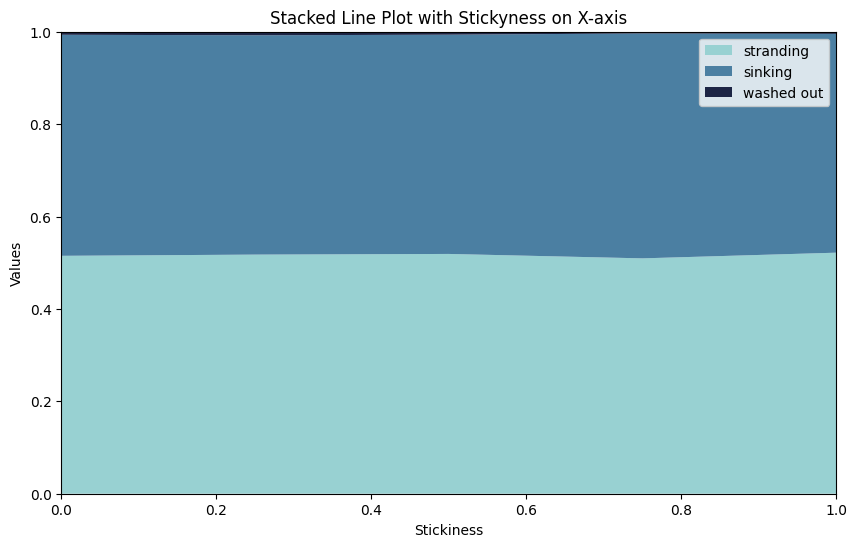

In [11]:
# get indices of all cases with initial size 1e-5, light threshold 30 and culling 3.56e-05
indices = df[(df['initial_size'] == 1e-5) & (df['light_limitation_threshold'] == 30) & (df['light_limited_culling_prop'] == 3.56e-05)].index

subset = slice_and_fill_subset(df, indices, cases)

plot_relative_cause_for_death(subset)

In [6]:
indices

Index([1, 4, 7, 10, 13, 16, 19, 22, 25, 28], dtype='int64')

(0.0, 1.0)

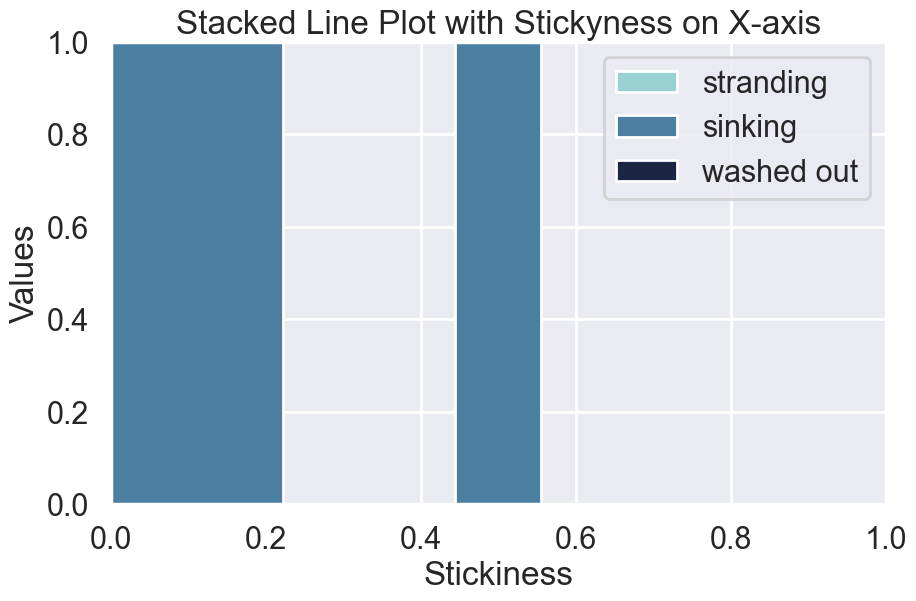

## hexmaps of death

19470


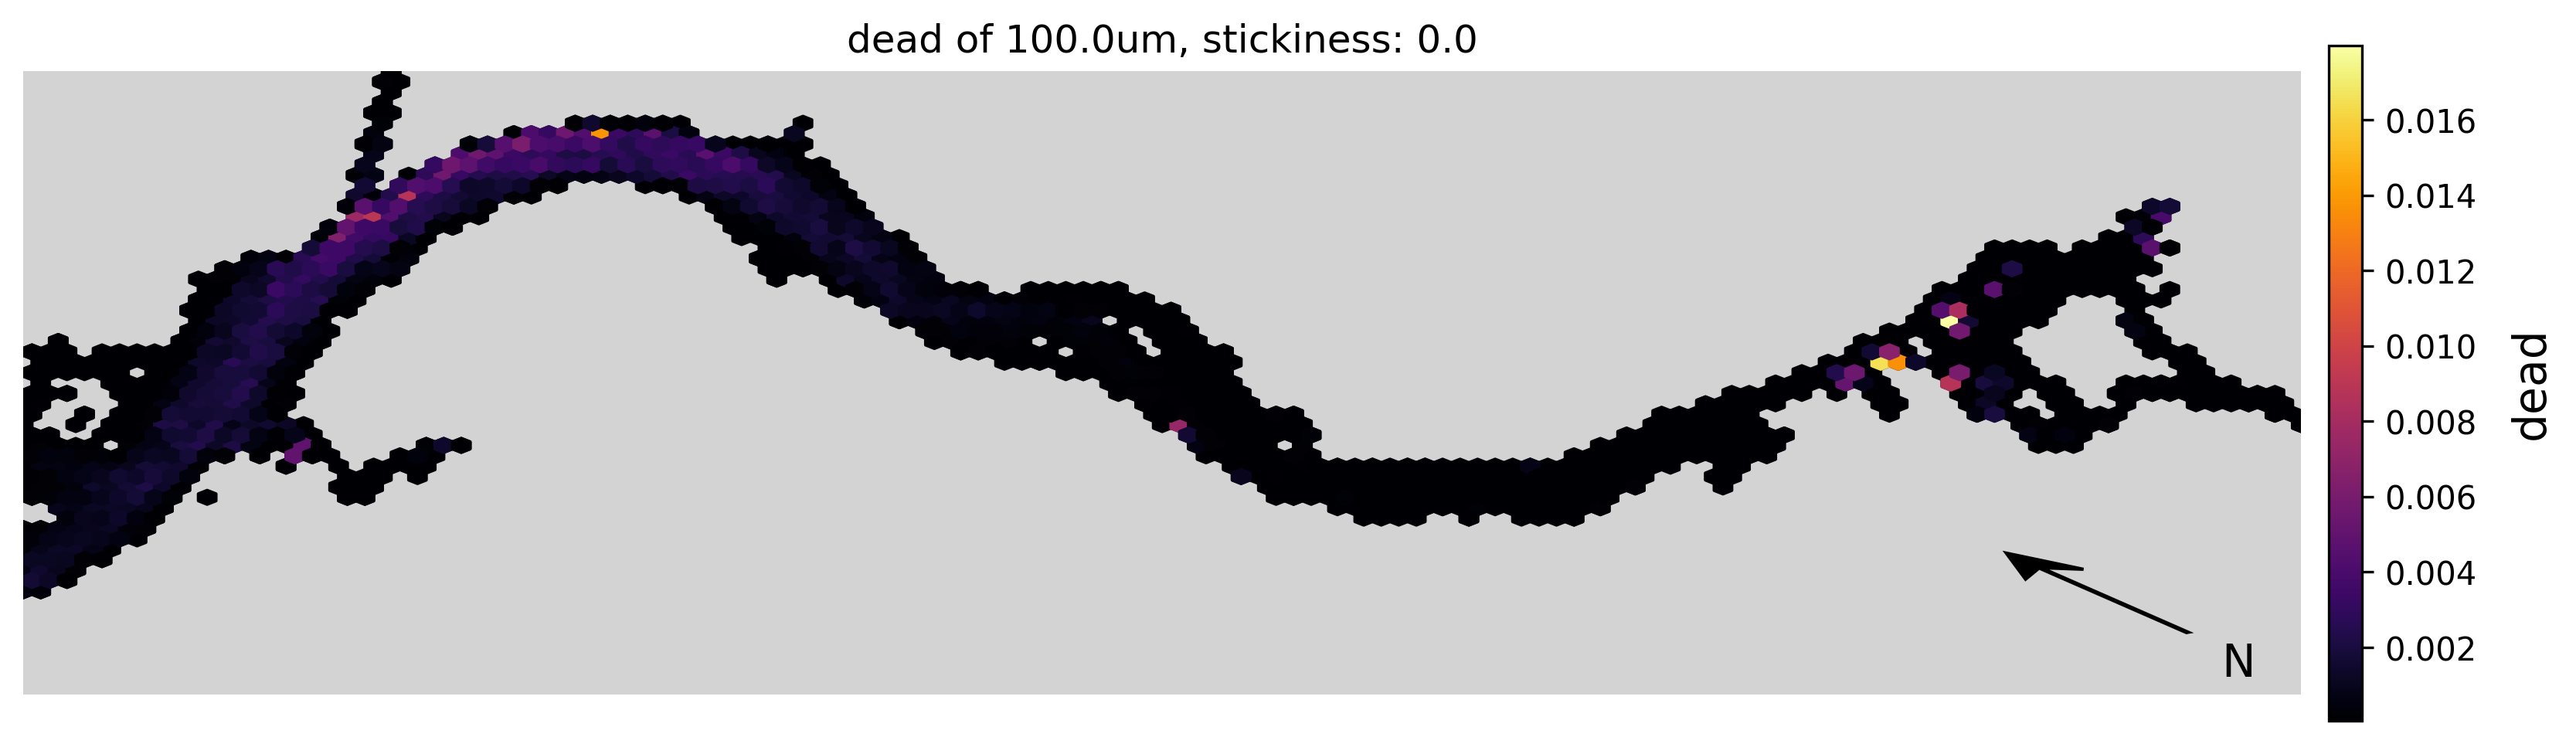

In [ ]:
%matplotlib inline
hexmap_of_death(cases[0],vmin=None,vmax=None)

10491


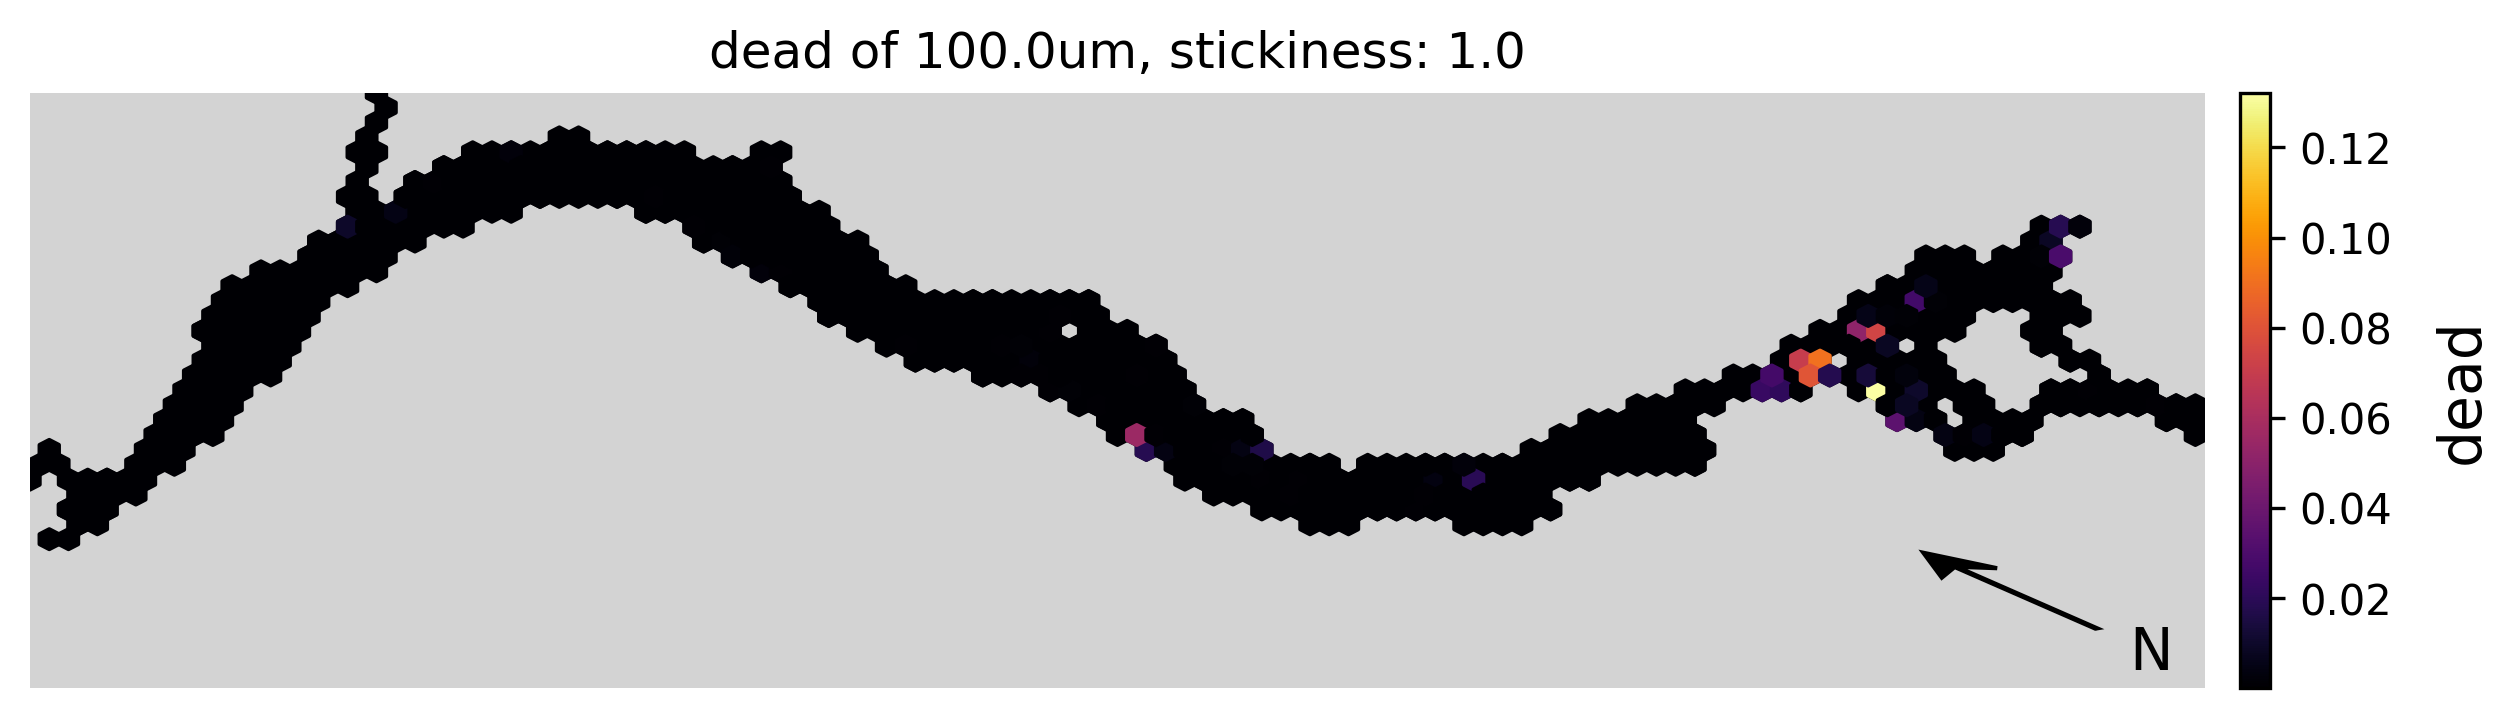

In [ ]:
%matplotlib inline
hexmap_of_death(cases[4],vmin=None,vmax=None,num_bins=20)

## Create stickiness SA plots

 1e-5 initial size, 30 light threshold and 3.56e-05 culling

In [ ]:
# df where initial_size == 1e-5, light_limitation_threshold	== 30, light_limited_culling_prop == 3.56e-05
subset_of_cases = df[(df['initial_size'] == 1e-5) & (df['light_limitation_threshold'] == 30) & (df['light_limited_culling_prop'] == 3.56e-05)]
subset_of_cases

,initial_size,stickiness,light_limitation_threshold,light_limited_culling_prop
1,0.00001,0.000000,30,0.000036
4,0.00001,0.111111,30,0.000036
7,0.00001,0.222222,30,0.000036
10,0.00001,0.333333,30,0.000036
13,0.00001,0.444444,30,0.000036
16,0.00001,0.555556,30,0.000036
19,0.00001,0.666667,30,0.000036
22,0.00001,0.777778,30,0.000036
25,0.00001,0.888889,30,0.000036
28,0.00001,1.000000,30,0.000036


In [ ]:
column_names = ['radius', 'stickiness', 'illumination_threshold', 'probability_of_culling', 'cause_of_death']
cause_of_death_df = pd.DataFrame(columns=column_names)



for ii in range(len(cases)):

    case = cases[ii]
    track_data = load_track_data(case)
    case_info = read_case_info_file(case)
    
    r = case_info['full_case_params']['class_dicts']['particle_properties']['radius_spherical']['initial_value']
    a = case_info['full_case_params']['class_dicts']['particle_properties']['collision_very_fine_silt']['stickyness']
    i = case_info['full_case_params']['class_dicts']['trajectory_modifiers']['light_starvation_induced_mortality']['required_illumination']
    p = case_info['full_case_params']['class_dicts']['trajectory_modifiers']['light_starvation_induced_mortality']['probability_of_culling']

    cause_of_death = track_data['cause_of_death']
    cause_of_death = cause_of_death[-1,:]

    # create subset df
    cause_of_death_subset_df = pd.DataFrame({'cause_of_death': cause_of_death})

# Repeat values of r, a, i, and p to match the length of cause_of_death
    params_subset_df = pd.DataFrame({
        column_names[0]: [r] * len(cause_of_death),
        column_names[1]: [a] * len(cause_of_death),
        column_names[2]: [i] * len(cause_of_death),
        column_names[3]: [p] * len(cause_of_death)